# Generating Dataset for Time Alignment Study

by Jacob Stallings

In [ ]:
#hide
#all_slow

In [ ]:
import os
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import torch
import librosa
from fastai.data.all import *
from fastproaudio.core import *

In [ ]:
path_audiomdpi = get_audio_data(URLs.MARCO)
horn = path_audiomdpi / "LeslieHorn"; horn.ls()
path_dry = horn /'dry'
audio_extensions = ['.m3u', '.ram', '.au', '.snd', '.mp3','.wav']
fnames_dry = get_files(path_dry, extensions=audio_extensions)
PATH = horn 

In [ ]:
# First, resample with librosa
y, sr = librosa.load(os.path.join(PATH, fnames_dry[0]), sr=44100)
y_16k = librosa.resample(y, sr, 16000)
y.shape, y_16k.shape


((110250,), (40000,))

In [ ]:
# waveform, sample_rate = torchaudio.load(os.path.join(PATH,fnames_dry[0]))
sample = y_16k

hi
0 0
hi
16000 13006
hi
32000 30180
hi
48000 51297


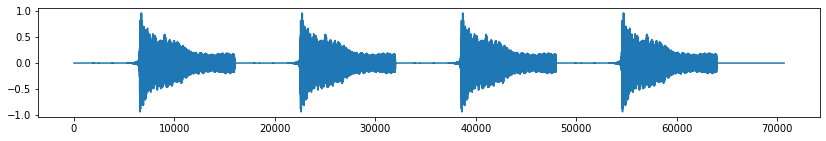

In [ ]:
# sample = waveform.numpy() # just simplify array dimensions for this demo
# sample = sample[int(0.6*sample_rate):]  # chop off the silence at the front for this demo

sample_rate = 16000

# Chop off silence
# Get the first nonzero value
onset = np.nonzero(sample)[0][0]
sample = sample[onset:]

# Detect the loudest part of the audio and split it there
peak = np.argmax(sample)
sample_pre = sample[:peak]
sample_post = sample[peak:]

track_length = sample_rate*4
sample_len = sample.shape[-1]
sample_len_post = sample_post.shape[-1]
sample_len_pre = sample_pre.shape[-1]
target = np.zeros(track_length+sample_len_pre)
input = np.zeros(track_length+ sample_len_pre)
click = np.zeros(track_length)

grid_interval = sample_rate # 1 sec

n_intervals = track_length // grid_interval
for i in range(n_intervals):
    start = grid_interval*i + sample_len_pre
    click[start] = 1                          # click track
    end_post = min(start + sample_len_post, track_length)
    end = min(start+sample_len, track_length)
    target[start:end_post] = sample_post[0:end_post-start]  # paste the sample on the grid
    target[grid_interval*i:start] = sample_pre
    print('hi')
    # mess up the paste location
    rand_start = max(0, start-sample_len_pre + np.random.randint(-grid_interval//4,grid_interval//4))
    print(start-sample_len_pre, rand_start)
    rand_end = min( rand_start+sample_len, track_length )
    input[rand_start:rand_end] = sample[0:rand_end-rand_start]

fig = plt.figure(figsize=(14, 2))
plt.plot(target)

Regarding the above, we want to include the onset of the transient but not the silence in the beginning of the clips. We could do a linear search of the sample from the left to find the first nonzero value, then clip the sound from there and paste it so that the grid corresponds with the max

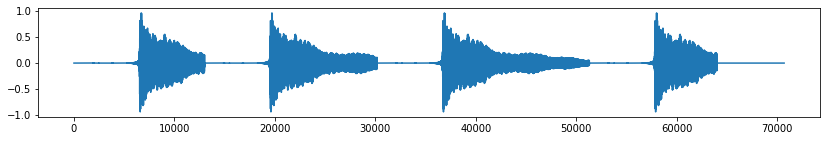

In [ ]:
fig = plt.figure(figsize=(14, 2))
plt.plot(input)

Note how the onset of the transients is preserved at the cost of chopping off some of the tails. This tradeoff happens in real single-track editing as well, but we could make the decision to prioritize keeping the tails of the previous hit and dropping the onset of the transient of the next hit.

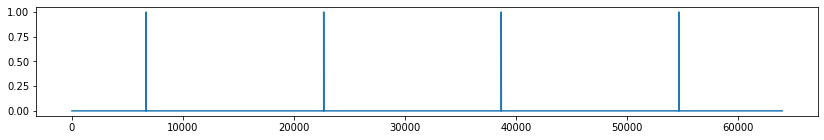

In [ ]:
fig = plt.figure(figsize=(14, 2))
plt.plot(click)

In [ ]:
def gen_pairs(fname, sample_rate=16000, preserve_onset=True, num_hits=4):

    # First, resample with librosa
    y, old_sr = librosa.load(os.path.join(PATH, fname), sr=44100)
    y_16k = librosa.resample(y, old_sr, sample_rate)

    sample = y_16k
    # Refactor into function
    # sample = waveform[0].numpy() # just simplify array dimensions for this demo
    # sample = sample[int(0.6*sample_rate):]  # chop off the silence at the front for this demo

    # Chop off silence
    # Get the first nonzero value
    if preserve_onset:
        onset = np.nonzero(sample)[0][0]
        sample = sample[onset:]

    # Detect the loudest part of the audio and split it there
    peak = np.argmax(sample)
    sample_pre = sample[:peak]
    sample_post = sample[peak:]

    track_length = sample_rate*num_hits
    sample_len = sample.shape[-1]
    sample_len_post = sample_post.shape[-1]
    sample_len_pre = sample_pre.shape[-1]
    target = np.zeros(track_length+sample_len_pre)
    input = np.zeros(track_length+ sample_len_pre)
    click = np.zeros(track_length)

    grid_interval = sample_rate
    # bpm = 60

    n_intervals = track_length // grid_interval
    for i in range(n_intervals):
        start = grid_interval*i + sample_len_pre
        click[start] = 1                          # click track
        end_post = min(start + sample_len_post, track_length)
        end = min(start+sample_len, track_length)
        target[start:end_post] = sample_post[0:end_post-start]  # paste the sample on the grid
        target[grid_interval*i:start] = sample_pre
        # mess up the paste location
        rand_start = max(0, start + np.random.randint(-grid_interval//4,grid_interval//4))
        rand_end = min( rand_start+sample_len, track_length )
        input[rand_start:rand_end] = sample[0:rand_end-rand_start]
    
    return input, target, click

Let's generate a trial dataset of let's say, 10 of these trios. (Eventually, we want to do the whole `LeslieHorn/dry` set).

In [ ]:
foldername = 'timeAlignData_mono'
if not os.path.isdir(foldername): os.mkdir(foldername)
bpm = 60

# Make all the dirs
for sub in ['Train', 'Test', 'Val']:
    if not os.path.isdir(os.path.join(foldername, sub)) : os.mkdir(os.path.join(foldername, sub))

train_split = 0.7

fnames_0 = fnames_dry[:len(fnames_dry)//2]
fnames_1 = fnames_dry[len(fnames_dry)//2:]

if len(fnames_0) < len(fnames_1) : size = len(fnames_0)
else: size = len(fnames_1)

for idx in range(size):
    if idx / size > 0.9: subset = 'Test'
    elif idx / size > 0.7: subset = 'Val'
    else: subset = 'Train'

    input0, target0, click0 = gen_pairs(fnames_0[idx])
    input1, target1, click1 = gen_pairs(fnames_1[idx])
    input0 = torch.as_tensor(input0, dtype=torch.float32).unsqueeze(0)
    target0 = torch.as_tensor(target0, dtype=torch.float32).unsqueeze(0)
    click0 = torch.as_tensor(click0, dtype=torch.float32).unsqueeze(0)

    input1 = torch.as_tensor(input1, dtype=torch.float32).unsqueeze(0)
    target1 = torch.as_tensor(target1, dtype=torch.float32).unsqueeze(0)
    click1 = torch.as_tensor(click1, dtype=torch.float32).unsqueeze(0)

    input0_fname = 'input_' + str(idx) + '-1'+'__' + '1__' + str(bpm) + '.wav'
    torchaudio.save(os.path.join(foldername, subset, input0_fname), src=input0, sample_rate=sample_rate)

    input1_fname = 'input_' + str(idx) + '-2'+'__' + '1__' + str(bpm) + '.wav'
    torchaudio.save(os.path.join(foldername, subset, input1_fname), src=input1, sample_rate=sample_rate)

    target0_fname = 'target_' + str(idx) + '-1'+'__'+ '1__'  + str(bpm) + '.wav'
    torchaudio.save(os.path.join(foldername, subset, target0_fname), src=target0, sample_rate=sample_rate)

    target1_fname = 'target_' + str(idx) + '-2'+'__'+ '1__'  + str(bpm) + '.wav'
    torchaudio.save(os.path.join(foldername, subset, target1_fname), src=target1, sample_rate=sample_rate)

    click0_fname = 'input_' + str(idx) + '-0'+'__'+ '1__'  + str(bpm) + '.wav'
    torchaudio.save(os.path.join(foldername, subset, click0_fname), src=click0, sample_rate=sample_rate)

    click1_fname = 'target_' + str(idx) + '-0'+'__'+ '1__'  + str(bpm) + '.wav'
    torchaudio.save(os.path.join(foldername, subset, click1_fname), src=click1, sample_rate=sample_rate)


    
    


Lets examine the mini dataset to make sure that it's ok to use.